In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data_1 = pd.read_csv('../input/monthly-us-auto-registration-tho.csv', sep=';')
data_2 = pd.read_csv('../input/weekly-closings-of-the-dowjones-.csv')

In [4]:
data_1.columns = ['Month', 'Quantity']
series_1 = data_1['Quantity']
data_2.columns = ['Week', 'Index']
series_2 = data_2['Index']

In [5]:
def plot_ts_and_points(ts, start_point, step):
    new_series = [None for i in range(len(ts))]
    for i in range(len(ts)):
        pos = start_point + step * i
        if pos >= len(ts):
            break
        new_series[pos] = ts[pos]
    new_series = pd.Series(new_series)
    
    with plt.style.context('bmh'):
        plt.figure(figsize=(16, 8))
        ts_ax = plt.axes()
        ts.plot(ax=ts_ax, color='blue')
        new_series.plot(ax=ts_ax, style='ro')

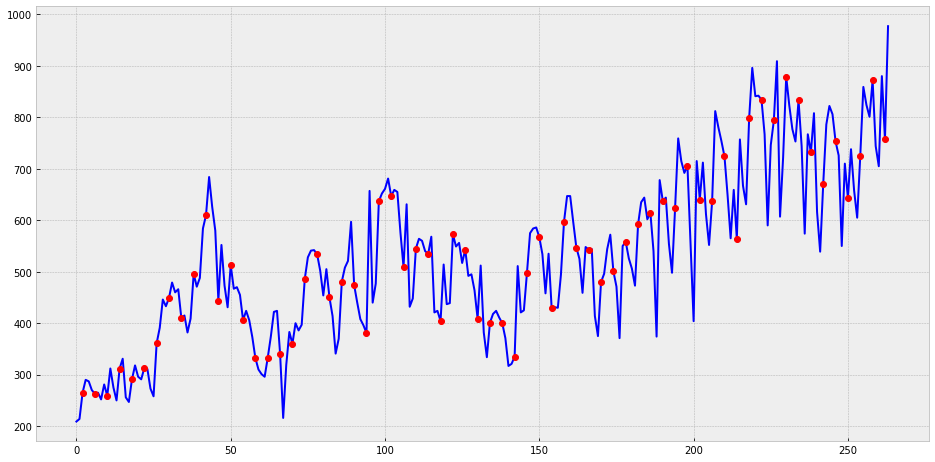

In [6]:
plot_ts_and_points(series_1, 2, 4)

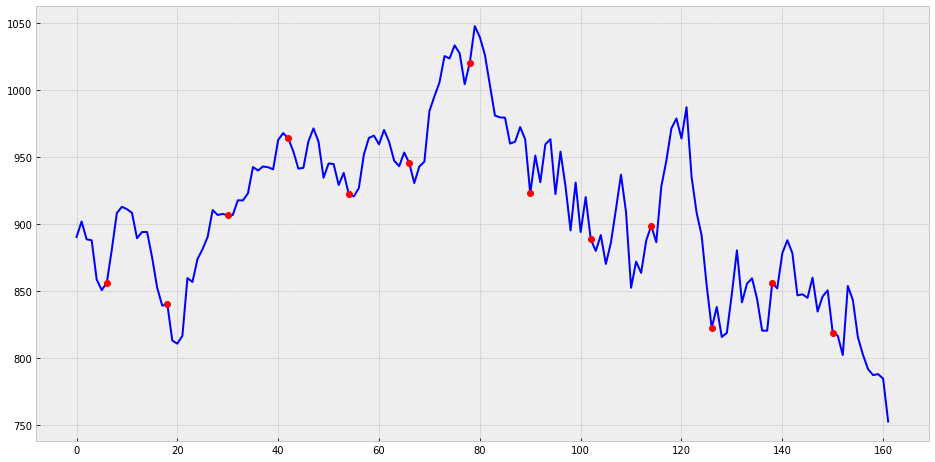

In [7]:
plot_ts_and_points(series_2, 6, 12)

Ни у одного из графиков сезонности не нашли, не на глаз не перебором

In [8]:
from statsmodels.tsa.stattools import adfuller

In [9]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [10]:
test_stationarity(series_1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [11]:
test_stationarity(series_1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.225039
p-value                          0.662733
#Lags Used                      15.000000
Number of Observations Used    248.000000
Critical Value (1%)             -3.456996
Critical Value (5%)             -2.873266
Critical Value (10%)            -2.573019
dtype: float64


In [12]:
from scipy.stats import boxcox

In [13]:
series_1 = boxcox(series_1, 0)
series_2 = boxcox(series_2, 0)

In [14]:
test_stationarity(series_1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.941628
p-value                          0.312738
#Lags Used                      14.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


In [15]:
test_stationarity(series_1)

Results of Dickey-Fuller Test:
Test Statistic                  -1.941628
p-value                          0.312738
#Lags Used                      14.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


Хоть у нас сезоности и нет, но преобразование boxcox всё равно делает наш ряд более стационарным по Дики_Фулеру (на кореллограммах изменений не видно - проверял). Потому оставим его 

In [16]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

### Дифференцируем 1-й ряд

In [17]:
import numpy as np

In [18]:
series_1_diff = np.diff(series_1, 2)

Продифференцируем два раза. Опытно получили что это лучший вариант.

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


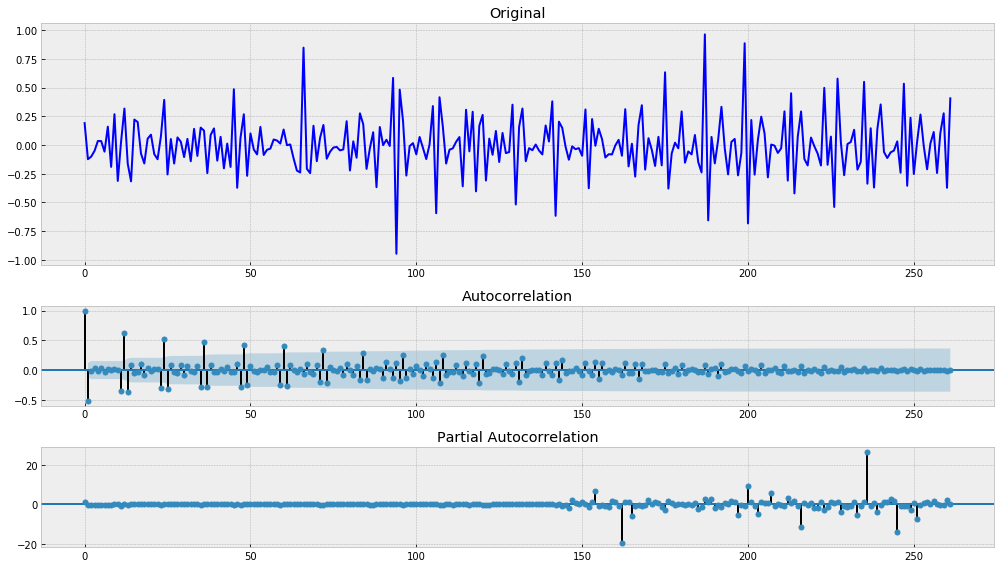

In [19]:
tsplot(series_1_diff)

In [20]:
test_stationarity(series_1_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.075967e+01
p-value                        2.539779e-19
#Lags Used                     1.200000e+01
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


Пусть тест Дики_ф... показывает хорошие результаты, все же на коррелограмме видим признаки нестационарности. Зная что это за ряд, и что отсчет идет в месяцах попробуем продифференцировать по 12

In [21]:
series_1_final = series_1_diff[12:] - series_1_diff[:-12]

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


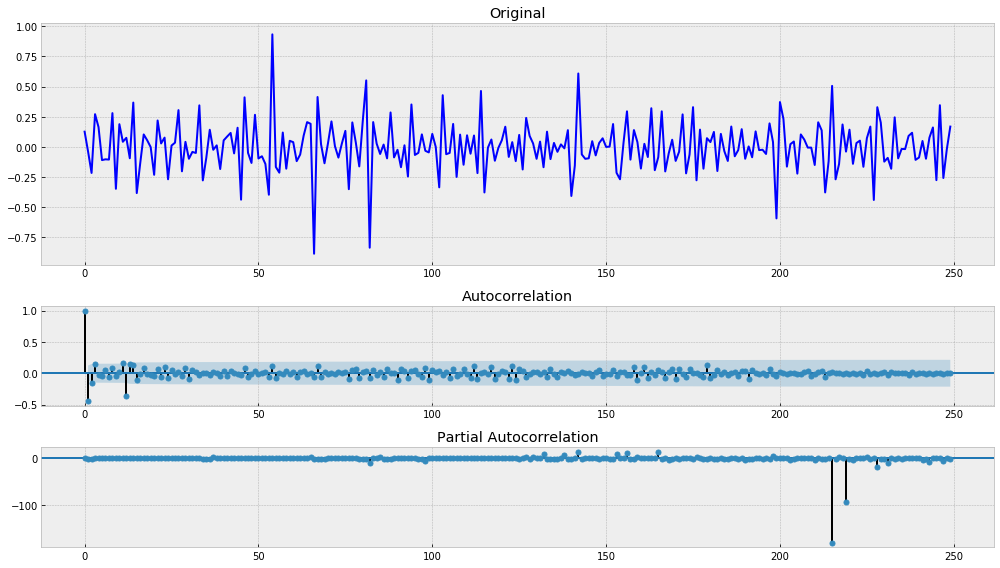

In [22]:
tsplot(series_1_final)

И получили хороший результат

### Дифференцируем 2-й ряд

In [23]:
series_2_diff = np.diff(series_2, 1)

Продифференцируем один раз.

/opt/conda/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


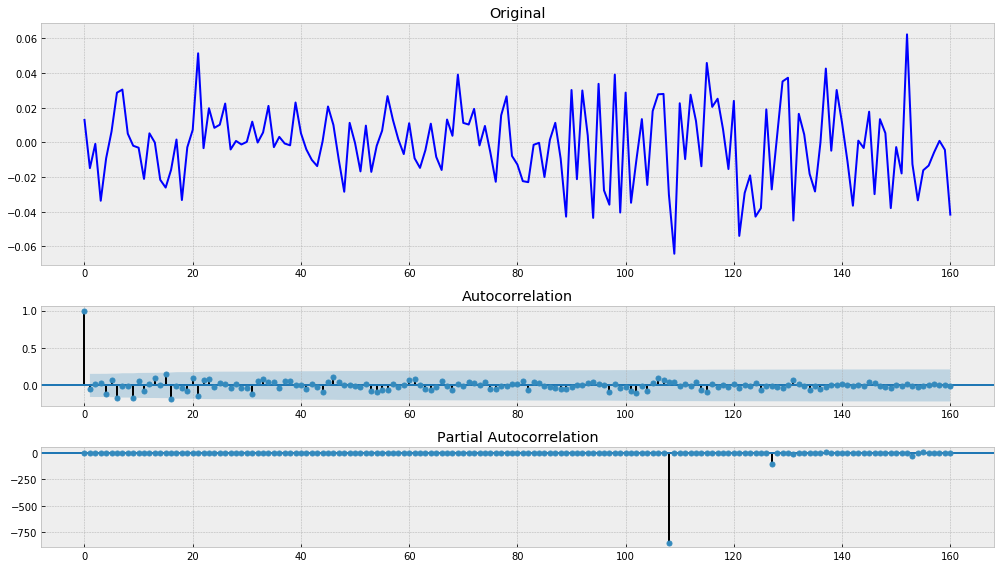

In [24]:
tsplot(series_2_diff)

In [25]:
test_stationarity(series_2_diff)

Results of Dickey-Fuller Test:
Test Statistic                -1.299582e+01
p-value                        2.751609e-24
#Lags Used                     0.000000e+00
Number of Observations Used    1.600000e+02
Critical Value (1%)           -3.471896e+00
Critical Value (5%)           -2.879780e+00
Critical Value (10%)          -2.576495e+00
dtype: float64


Получили достаточно неплохой результат